# Think Bayes - Chapter 10

Following A. B. Downey's book *Think Bayes*, but using Julia as opposed to Python.

In [1]:
using Statistics, Distributions, Plots, Printf

## Baysian bandits

For this chapter specifically will implement the idea of multiarmed bandits and trying to balance exploration and exploitation.

The setup is that there are four machines with probabilities of winning $w_{1,2,3,4}=0.1,\, 0.3,\, 0.49,\, 0.52$. So basically on machine is mis-configured and it will allow the player to win in the long term provided the player can identify and exploit the machine.

The player does not know which machine it is and randomly trying all machines is likely to lead to large losses before any gains. The strategy is therefore to select which machine to play on randomly, but in proportion to probability that each machine is the best

We update the priors after every game

## Statics

The components that will be used to model the situation

In [11]:
"""
The bandit structure. Stores the probability of winning,
the number of times the bandit has been played, the initial
prior and the current posterior of the winning probability
"""
struct bandit
    win_w::Float64 # true probability of winning
    w_bins_arr::Array{Float64} # winning probability values
    w_init_prior_arr::Array{Float64} # winning prob prior distr
    w_post_arr::Array{Float64} # current winning prob posterior
    won_last_game::Bool # last game was won
    
    ###
    bandit(
        winning_prob::Float64,
        w_arr::Array{Float64},
        w_prior_arr::Array{Float64}
    ) = new(
        winning_prob,
        w_arr,
        w_prior_arr,
        copy(w_prior_arr),
        false
    )
    
    ###
    bandit(
        winning_prob::Float64,
        w_arr::Array{Float64},
        w_prior_arr::Array{Float64},
        w_post_arr::Array{Float64}
    ) = new(
        winning_prob,
        w_arr,
        w_prior_arr,
        w_post_arr,
        false
    )
    
    ###
    bandit(
        winning_prob::Float64,
        w_arr::Array{Float64},
        w_prior_arr::Array{Float64},
        w_post_arr::Array{Float64},
        won_last_game::Bool
    ) = new(
        winning_prob,
        w_arr,
        w_prior_arr,
        w_post_arr,
        won_last_game
    )
end

####

"""
given the bandit play a game and, based on win lose update the 
posterior
"""
function bandit_post_update(bt::bandit)::bandit
    # play the game and select the correct likelyhood
    # of winning losing. Then apply this likelihood
    # to update prior and arrive at posterior
    if rand() < bt.win_w
        w_post_arr = bt.w_post_arr .* bt.w_bins_arr
        won_last_game=true
    else
        w_post_arr = bt.w_post_arr .* (1.0 .- bt.w_bins_arr)
        won_last_game=false
    end
    
    # normalize
    w_post_arr = w_post_arr / sum(w_post_arr) 
    
    # save result as a new bandit
    new_bt  = bandit(
        bt.win_w,
        bt.w_bins_arr,
        bt.w_init_prior_arr,
        w_post_arr,
        won_last_game
    )
    
    return new_bt
end

####

"""
Given two bandits compute the probability that the first one
offers better rewards, i.e. higher probability of winning
"""
function prob_first_bandit_better(
    first_bandit::bandit,
    second_bandit::bandit
)::Float64
    
    
    prob_better = 0.0
    #
    # go through all possible combinations of the bins in the first and second bandit
    # count probabilities of such events ocurring.
    for (i_f, (first_win_bin, first_win_post)) in enumerate(zip(first_bandit.w_bins_arr, first_bandit.w_post_arr))
        for (i_s, (second_win_bin, second_win_post)) in enumerate(zip(second_bandit.w_bins_arr, second_bandit.w_post_arr))
            if first_win_bin > second_win_bin
                prob_better += first_win_post * second_win_post
            end
        end
    end
    
    
    return prob_better
end

####

"""
Given a list of bandits compute the probability for each of them, that it is better
than the rest
"""
function prob_better_than_rest(bandit_arr::Array{bandit}, better_threshold::Float64=0.5)::Array{Float64}

    prob_better_arr = zeros(length(bandit_arr))
    #
    # go through all bandits
    for (i_cur_bandit, cur_bandit) in enumerate(bandit_arr)
        cur_prob = 1.0
        
        # go through all bandits other than this one
        for other_bandit in bandit_arr[1:end .!= i_cur_bandit]
            cur_prob *= prob_first_bandit_better(cur_bandit, other_bandit)
        end
        
        prob_better_arr[i_cur_bandit] = cur_prob
    end
    

    return prob_better_arr
end

####

w_arr = Vector(LinRange(0.001, 1-0.001, 1000))
w_prior_arr = ones(length(w_arr)) ./ length(w_arr)

trial_bandit_arr = [
    bandit(0.6, w_arr, w_prior_arr),
    bandit(0.15, w_arr, w_prior_arr),
    bandit(0.1, w_arr, w_prior_arr),
    bandit(0.2, w_arr, w_prior_arr)
]

###

prob_better_than_rest(trial_bandit_arr)

4-element Array{Float64,1}:
 0.12462537487017503
 0.12462537487017503
 0.12462537487017503
 0.12462537487017503

### Some plots to test statics

In [12]:
# update posteriors on all bandits
for i=1:30
    for i_bt in 1:length(trial_bandit_arr)
        trial_bandit_arr[i_bt]= bandit_post_update(trial_bandit_arr[i_bt])
    end
end



nothing

nothing

nothing

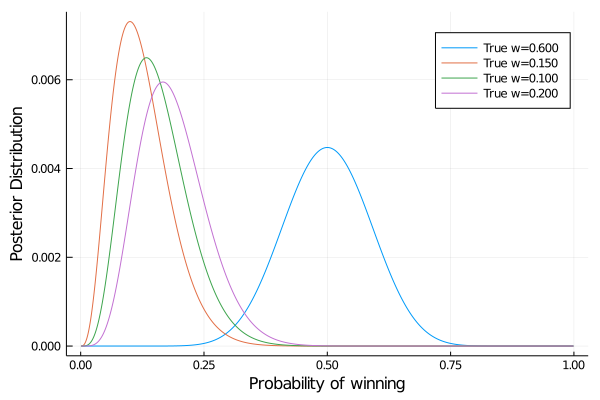

In [13]:
function plot_bandit_arr(bandit_arr::Array{bandit})
    
    for (i_bt, cur_bt) in enumerate(bandit_arr)
    
        res=nothing
        if i_bt == 1
            plot(
                bandit_arr[i_bt].w_bins_arr,
                bandit_arr[i_bt].w_post_arr,
                label=@sprintf("True w=%.3f", bandit_arr[i_bt].win_w),
                xlabel="Probability of winning",
                ylabel="Posterior Distribution"
            )
        elseif i_bt < length(bandit_arr)
            plot!(
                    bandit_arr[i_bt].w_bins_arr,
                    bandit_arr[i_bt].w_post_arr,
                    label=@sprintf("True w=%.3f", bandit_arr[i_bt].win_w)
            )
        else
            res=plot!(
                    bandit_arr[i_bt].w_bins_arr,
                    bandit_arr[i_bt].w_post_arr,
                    label=@sprintf("True w=%.3f", bandit_arr[i_bt].win_w)
            )
        end
        
        # wont display in JH without this
        display(res)
    end
end


####

plot_bandit_arr(trial_bandit_arr)

## Exploration strategies

In [14]:
"""
Random exploration strategy where one tries a random badnit every time
"""
function random_exploration(
    bandit_arr::Array{bandit},
    trial_count::Int64=10
)::Tuple{Array{bandit}, Int64}
    
    # use categorical distribution
    # to select bandits with equal probability
    bandit_distr = Categorical(ones(length(bandit_arr))/length(bandit_arr))
    win_count = 0
    
    for i_trial=1:trial_count
        i_bandit = rand(bandit_distr)
        
        # get the old bandit and update it to get a new one
        old_bandit = bandit_arr[i_bandit]
        new_bandit = bandit_post_update(old_bandit)
        
        # record win
        win_count += Int(new_bandit.won_last_game)
        
        # change bandit
        bandit_arr[i_bandit] = new_bandit
    end
    
    return bandit_arr, win_count
end

####

"""
Exploration strategy based on choosing by probability of a bandit being best
"""
function bybest_exploration(
    bandit_arr::Array{bandit},
    trial_count::Int64=10
)::Tuple{Array{bandit}, Int64}
    
    uni_dist = Uniform()
    win_count = 0
    
    for i_trial=1:trial_count
        # find the probability of different bandits to be best
        prob_better_arr = prob_better_than_rest(bandit_arr)
        prob_better_arr /= sum(prob_better_arr)
        #
        i_bandit = findfirst(rand(uni_dist) .< cumsum(prob_better_arr .+ 1e-12))
        # i_bandit = findfirst(rand(uni_dist) .< cumsum([0.25, 0.25, 0.25, 0.25] .+ 1e-12))
        
        # get the old bandit and update it to get a new one
        old_bandit = bandit_arr[i_bandit]
        new_bandit = bandit_post_update(old_bandit)
        
        # record win
        win_count += Int(new_bandit.won_last_game)
        
        # change bandit
        bandit_arr[i_bandit] = new_bandit
        
        @printf("%d\r", i_bandit)
    end
    
    return bandit_arr, win_count
end

####

trial_count = 100

random_expl_trial_bandit_arr = copy(trial_bandit_arr)
random_expl_trial_bandit_arr, rand_win_count = random_exploration(random_expl_trial_bandit_arr, trial_count)
@printf("Random. Victory count %d\n", rand_win_count)

bybest_expl_bandit_arr = copy(trial_bandit_arr)
bybest_expl_bandit_arr, bybest_win_count = bybest_exploration(bybest_expl_bandit_arr, trial_count)
@printf("ByBest. Victory count %d\n", bybest_win_count)

#plot_bandit_arr(random_expl_trial_bandit_arr)

Random. Victory count 27
ByBest. Victory count 54


nothing

nothing

nothing

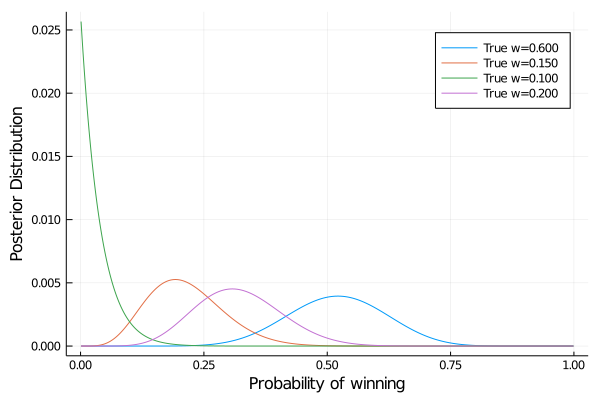

nothing

nothing

nothing

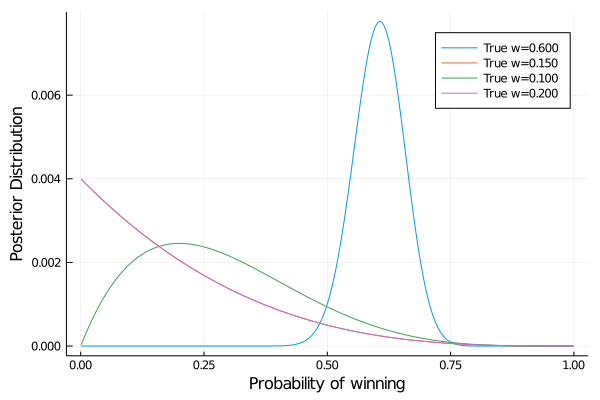

In [10]:

plot_bandit_arr(random_expl_trial_bandit_arr)
plot_bandit_arr(bybest_expl_bandit_arr)

In [15]:
(60+10+20+15)/4

26.25